In [11]:
import os
import sys
# ========== Project Root Path =================
this_path = os.path.abspath(sys.path[0])
print(this_path)
project_dir = 'Web3HackerNetwork'
w3hndex = this_path.index(project_dir)
root_path = this_path[0:w3hndex + len(project_dir)]
print(root_path)
# ---------- Local Library Path ----------------
lib_path = f'{root_path}/python'
print(lib_path)
if lib_path not in sys.path: sys.path.insert(0, lib_path)
# ---------- Local Libraries -------------------
from w3hn.datapipe.ingest.file_hacker_commit import FileHackerCommitIngester
from w3hn.datapipe.ingest.repo_file import RepoFileIngester
from w3hn.aws.aws_util import S3Util
import w3hn.hadoop.parquet_util as pq_util
# ----------------------------------------------

/home/bob/projects/Web3HackerNetwork/python
/home/bob/projects/Web3HackerNetwork
/home/bob/projects/Web3HackerNetwork/python


In [2]:
import pyarrow.parquet as papq

path = 'web3hackernetwork/data_pipeline/published/hacker_dependency_tfidf'
bucket_path=f'deadmandao/{path}'
s3_util = S3Util(bucket_name='deadmandao', profile='w3hn-admin')
hacker_dependency_tfidf = s3_util.read_parquet_table(path)
print(f'{hacker_dependency_tfidf.schema}')
print(f'{hacker_dependency_tfidf.num_rows} x {hacker_dependency_tfidf.num_columns}')


author: string
extension: string
dependency: string
tfidf: double
-- schema metadata --
org.apache.spark.version: '3.1.1'
org.apache.spark.sql.parquet.row.metadata: '{"type":"struct","fields":[{"' + 261
4030579 x 4


In [3]:
import duckdb
con = duckdb.connect()
results = con.execute("""
SELECT dependency, tfidf FROM hacker_dependency_tfidf
WHERE author = 'Brandon Williams <brandonwilliams@apache.org>'
ORDER BY tfidf DESC
""").arrow()
print(str(results.to_pandas()[slice(0,5)]))

                                          dependency  tfidf
0  org.apache.pig.backend.executionengine.ExecExc...  10.59
1                                   org.apache.pig.*   9.68
2  org.apache.cassandra.db.marshal.AbstractCompos...   9.68
3                   org.apache.pig.Expression.OpType   9.50
4              org.apache.hadoop.hdfs.MiniDFSCluster   7.65


In [5]:
path = 'web3hackernetwork/data_pipeline/curated/repo_dependency'
curated_repo_dependency = s3_util.read_parquet_table(path)
con = duckdb.connect()

In [42]:
sql = """
select extension, dependency, count(1) as num_repos, sum(file_count) as num_files
from curated_repo_dependency
where extension = '.py'
group by extension, dependency
having num_repos > 50
order by num_repos desc
"""
dep_popularity = con.execute(sql).arrow()
print(str(dep_popularity.to_pandas()[slice(0,5)]))
print(str(dep_popularity.to_pandas()[slice(400,405)]))


  extension dependency  num_repos num_files
0       .py         os       3445     41684
1       .py        sys       3224     27653
2       .py         re       2542     13752
3       .py       json       2105     12461
4       .py       time       2037     11874
    extension                  dependency  num_repos num_files
400       .py           tabulate.tabulate         58       121
401       .py                       fcntl         58        94
402       .py             fnmatch.fnmatch         58        80
403       .py  urllib.request.urlretrieve         58        66
404       .py            tensorflow.keras         57       219


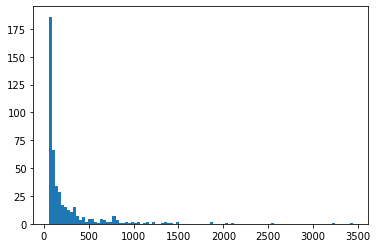

In [36]:
import matplotlib.pyplot as plt

# x = dep_popularity.to_pandas()
a = plt.hist(dep_popularity.column(2), 100)
py_dep_popularity = dep_popularity
# dep_popularity.column(2)

In [26]:
sql = """
SELECT count(1) FROM dep_popularity WHERE extension='.py' AND num_repos > 50
"""
num_below_threshold = con.execute(sql).arrow()
print(str(num_below_threshold.to_pandas()[slice(0,20)]))

   count(1)
0       464


464 python dependencies have fewer than 50 repos associated with them (that number will climb as we pull more repos).

That gives us an idea of our threshold for including libraries in the embedding. The lower the number of repositories using the library, the less is its importance as a comparative metric.

The number of libraries also explodes as you go lower on the list. Usage count has an extremely long tail, so raising the threshold just a bit removes a lot of low-signal data from the model.


  extension           dependency  num_repos num_files
0     .java       java.util.List        773     38110
1     .java  java.util.ArrayList        759     20480
2     .java  java.io.IOException        702     18675
3     .java        java.util.Map        670     17353
4     .java     java.util.Arrays        653      9852
    extension                                         dependency  num_repos  \
300     .java                     android.content.res.TypedArray         68   
301     .java                                  android.os.Parcel         68   
302     .java                    android.net.ConnectivityManager         68   
303     .java  com.fasterxml.jackson.databind.Deserialization...         68   
304     .java                          android.view.MenuInflater         67   

    num_files  
300       321  
301       583  
302       151  
303       153  
304       265  
   count(1)
0       428


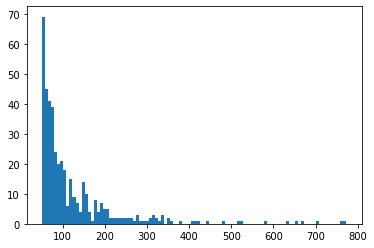

In [39]:
sql = """
select extension, dependency, count(1) as num_repos, sum(file_count) as num_files
from curated_repo_dependency
where extension = '.java'
group by extension, dependency
having num_repos > 50
order by num_repos desc
"""
dep_popularity = con.execute(sql).arrow()
print(str(dep_popularity.to_pandas()[slice(0,5)]))
print(str(dep_popularity.to_pandas()[slice(300,305)]))
a = plt.hist(dep_popularity.column(2), 100)

sql = """
SELECT count(1) FROM dep_popularity WHERE extension='.java' AND num_repos > 50
"""
num_below_threshold = con.execute(sql).arrow()
print(str(num_below_threshold.to_pandas()[slice(0,20)]))

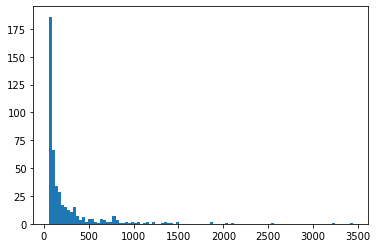

In [37]:
a = plt.hist(py_dep_popularity.column(2), 100)